In [419]:
import pandas as pd
import numpy as np
import ete3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, k_means, KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [69]:
soil = pd.read_csv('dataset/soilmoisture_dataset.csv')

In [70]:
soil.head()

,index,datetime,soil_moisture,soil_temperature,454,458,462,466,470,474,...,914,918,922,926,930,934,938,942,946,950
0,0,2017-05-23 14:06:17,33.51,34.8,0.082131,0.055863,0.050047,0.047925,0.047498,0.046464,...,0.152845,0.152615,0.152927,0.154240,0.155018,0.154725,0.154682,0.154275,0.153477,0.153929
1,1,2017-05-23 14:08:17,33.49,35.2,0.079510,0.055326,0.049116,0.047579,0.046745,0.046833,...,0.152715,0.153102,0.153551,0.153590,0.153688,0.153370,0.154021,0.155543,0.156220,0.156727
2,2,2017-05-23 14:10:17,33.46,35.4,0.080599,0.054065,0.049150,0.047537,0.046525,0.046032,...,0.152362,0.152158,0.153204,0.153942,0.154610,0.154629,0.155609,0.155545,0.154884,0.154485
3,3,2017-05-23 14:12:17,33.33,35.0,0.078024,0.054972,0.049052,0.047920,0.046883,0.046775,...,0.153281,0.153990,0.154499,0.155012,0.154691,0.154643,0.155405,0.155918,0.157645,0.157824
4,4,2017-05-23 14:14:17,33.32,35.3,0.079973,0.055335,0.049314,0.047373,0.047028,0.046963,...,0.152803,0.153085,0.153295,0.154230,0.155071,0.155624,0.156504,0.156859,0.156634,0.156176


In [71]:
X = soil.drop(['index', 'datetime'], axis=1)

In [72]:
X.head()

,soil_moisture,soil_temperature,454,458,462,466,470,474,478,482,...,914,918,922,926,930,934,938,942,946,950
0,33.51,34.8,0.082131,0.055863,0.050047,0.047925,0.047498,0.046464,0.046669,0.046834,...,0.152845,0.152615,0.152927,0.154240,0.155018,0.154725,0.154682,0.154275,0.153477,0.153929
1,33.49,35.2,0.079510,0.055326,0.049116,0.047579,0.046745,0.046833,0.046329,0.047021,...,0.152715,0.153102,0.153551,0.153590,0.153688,0.153370,0.154021,0.155543,0.156220,0.156727
2,33.46,35.4,0.080599,0.054065,0.049150,0.047537,0.046525,0.046032,0.046276,0.046886,...,0.152362,0.152158,0.153204,0.153942,0.154610,0.154629,0.155609,0.155545,0.154884,0.154485
3,33.33,35.0,0.078024,0.054972,0.049052,0.047920,0.046883,0.046775,0.046835,0.046996,...,0.153281,0.153990,0.154499,0.155012,0.154691,0.154643,0.155405,0.155918,0.157645,0.157824
4,33.32,35.3,0.079973,0.055335,0.049314,0.047373,0.047028,0.046963,0.046763,0.047051,...,0.152803,0.153085,0.153295,0.154230,0.155071,0.155624,0.156504,0.156859,0.156634,0.156176


In [73]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [433]:
n_clusters = 6
hc = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_hc = hc.fit_predict(X)

In [434]:
def get_distances(X, model, mode='l2'):
    """
    Popular solution to plot HCs here https://stackoverflow.com/a/12311782/2096747
    """
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d

        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights

In [435]:
def plot_test(model, title, **kwargs):
    distance, weight = get_distances(X,model)
    linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Clusters', fontsize=18)
    plt.ylabel('Similarity (0 when max)', fontsize=16)
    dendrogram(linkage_matrix, **kwargs)
    plt.show()

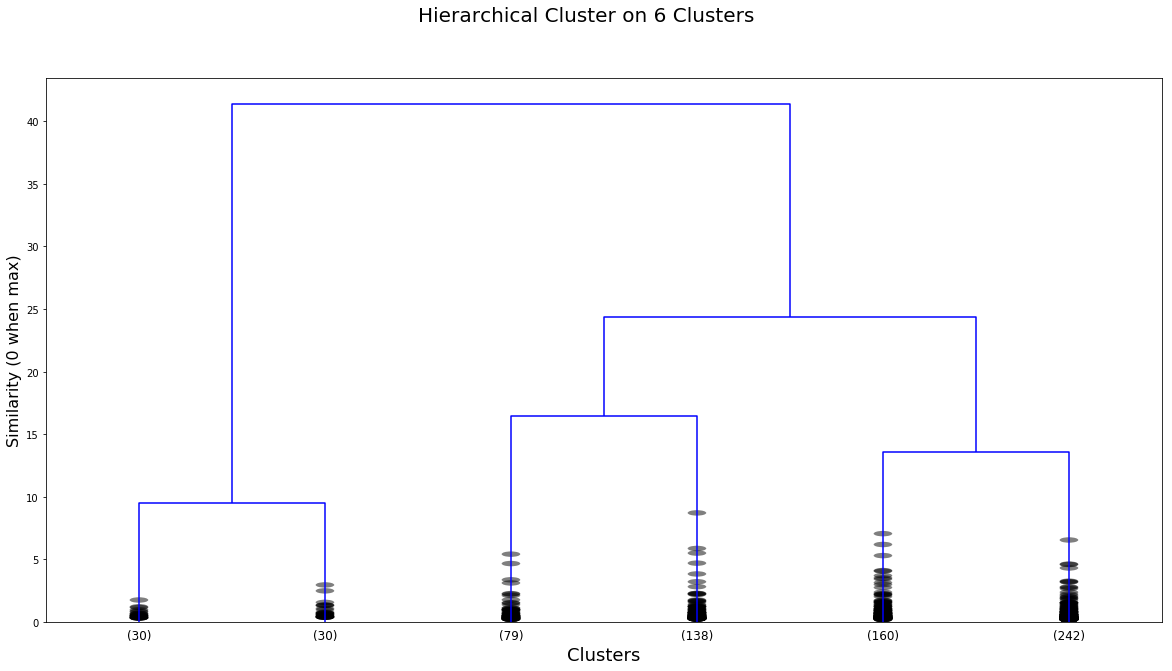

In [436]:
plot_title = 'Hierarchical Cluster on ' + str(n_clusters) + ' Clusters'
plot_test(hc, plot_title, count_sort='descending', color_threshold=1, truncate_mode='lastp', 
          p=n_clusters, show_contracted=True, show_leaf_counts=True)

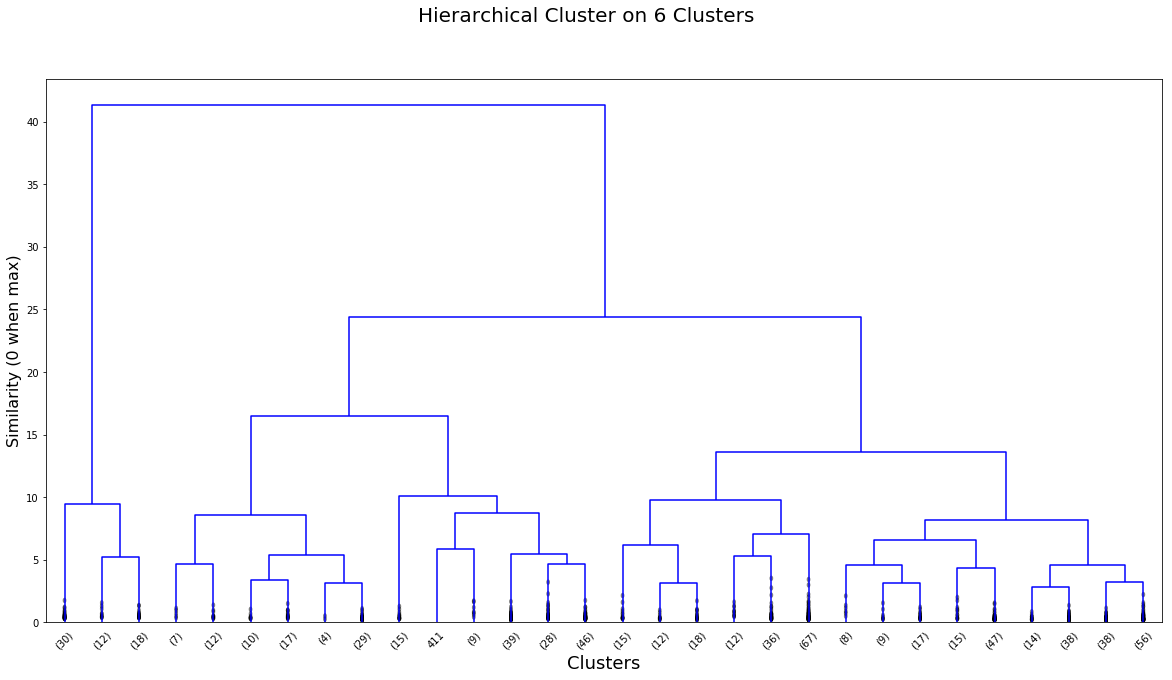

In [437]:
plot_title = 'Hierarchical Cluster on ' + str(n_clusters) + ' Clusters'
plot_test(hc, plot_title, count_sort='descending', color_threshold=1, truncate_mode='lastp', 
          p=30, show_contracted=True, show_leaf_counts=True)

In [400]:
# silhouette score for HC
silhouette_score(X, y_pred_hc)

0.5567592713535017

In [401]:
km = k_means(X, n_clusters=5)
y_pred_km = km[1]

In [402]:
# silhouette score for KMeans
silhouette_score(X, y_pred_km)

0.5641012856276295

In [425]:
k_centers = list(range(2, 20))
silhouette_scores_hc = []
for k in k_centers:
    cluster = AgglomerativeClustering(n_clusters=k)
    y_pred = cluster.fit_predict(X)
    score = round(silhouette_score(X, y_pred, metric='euclidean'), 4)
    silhouette_scores_hc.append(score)

In [426]:
k_centers = list(range(2, 20))
silhouette_scores_km = []
for k in k_centers:
    y_pred = k_means(X, n_clusters=k)[1]
    score = round(silhouette_score(X, y_pred, metric='euclidean'), 4)
    silhouette_scores_km.append(score)

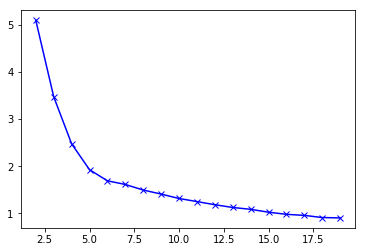

In [424]:
distortions = []
k_centers = list(range(2, 20))
for k in k_centers:
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    distortions.append(sum(np.min(cdist(X, cluster.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
plt.plot(k_centers, distortions, 'bx-')

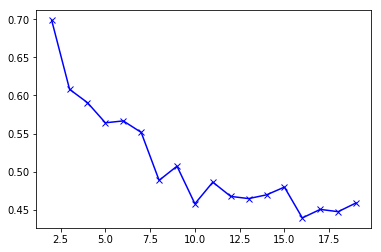

In [439]:
plt.plot(k_centers, silhouette_scores_km, 'bx-')

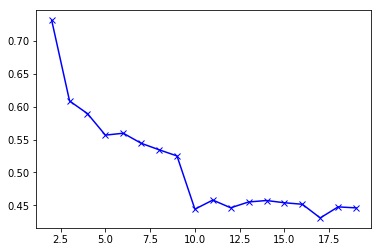

In [438]:
plt.plot(k_centers, silhouette_scores_hc, 'bx-')